# Annotation

<p>The task is to forecast store sales using the last year's sales data, which includes information about stores (their type, location, etc.), goods families, promotions, national and local events or holidays, transmissions and oil prices. 

In [ ]:
import os
os.chdir(os.environ['PROJECT_ROOT'])

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pathlib import Path

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

# First look at the data

In [ ]:
DATA_ROOT = Path('data')

In [ ]:
train_data = pd.read_csv(DATA_ROOT / 'kaggle' / 'store-sales-time-series-forecasting' / 'train.csv', index_col = 'id')
train_data.head()

In [ ]:
stores_data = pd.read_csv(DATA_ROOT / 'kaggle' / 'store-sales-time-series-forecasting' / 'stores.csv')
stores_data.head()

In [ ]:
oil_data = pd.read_csv(DATA_ROOT / 'kaggle' / 'store-sales-time-series-forecasting' / 'oil.csv')
oil_data.head()

In [ ]:
holidays_events_data = pd.read_csv(DATA_ROOT / 'kaggle' / 'store-sales-time-series-forecasting' / 'holidays_events.csv')
holidays_events_data.head()

In [ ]:
transactions_data = pd.read_csv(DATA_ROOT / 'kaggle' / 'store-sales-time-series-forecasting' / 'transactions.csv')
transactions_data.head()

In [ ]:
train_data = train_data.merge(stores_data, on='store_nbr', how='left')
train_data.head()

In [ ]:
train_data = train_data.merge(oil_data, on='date', how='left')
train_data.head()

In [ ]:
train_data = train_data.merge(holidays_events_data, on='date', how='left')
train_data.head()

In [ ]:
train_data = train_data.merge(transactions_data, on=('date', 'store_nbr'), how='left')
train_data.head()

<i>I chose merging on both columns 'date' and 'store_nbr', because 'train_data' and 'transactions_data' had these two common columns.</i>

In [ ]:
train_data.shape

In [ ]:
train_data.info()

<i> We can see that there are only 6 numerical features, other 10 features are non-numerical.<br>Since there are two columns in the table with similar names, it is necessary to rename them to avoid the confusion while analyzing data.</i>

In [ ]:
train_data['family'] = train_data['family'].str.lower()     # for easier reading
train_data = train_data.rename(columns={'type_x': 'store_type', 'type_y': 'event_type'})
train_data.head()

In [ ]:
numerical_features = train_data.select_dtypes(include='number').columns.tolist()
numerical_features.remove('store_nbr')
numerical_features.remove('cluster')
numerical_features

In [ ]:
categorical_features = train_data.select_dtypes(exclude='number').columns.tolist()
categorical_features.append('store_nbr')
categorical_features.append('cluster')
categorical_features

In [ ]:
train_data['family'].value_counts()

<i>As we can see, each family has a big number of observations, that is why it may have sense to build separate models for different categories</i>

In [ ]:
train_data.isna().mean()

<i>As we can see, only 16.5% observations have information about holiday or event provided that day. Actually, a number of NaN values in 'event_type', 'locale', 'locale_name', 'description', 'transferred' is pretty high, but if we are talking about holidays it seems to be a normal number. I mean, we don't need to remove this features right now. It is necessary to look on how these features influence on the target and make a final decision after that. Talking about filling this NaN values, maybe it is a good idea to make one binary variable, which will tell us if there is a holiday in a particular day or not.
<p>'dcoilwtico' coefficient is easier to describe. Two days a week (at the weekend) there is no information about oil price (the prove is below), that is why the coeeficient is near 2/7 (actually, it is little bigger, because the value of 'dcoilwtico' feature can also be NaN during some holidays.
<p>Talking about 'transactions' feature, I think that this number of NaN values can be connected with some national or local holidays, when some of the stores could be closed. But it is also necessary to check this guess.</i>

In [ ]:
oil_data_copy = oil_data.copy()
oil_data_copy['date'] = pd.to_datetime(oil_data_copy['date'])
oil_data_copy['day'] = oil_data_copy['date'].dt.day_name()
oil_data_copy['day'].unique()

<i>That is the prove of the fact that there is no oil price at the weekend.</i>

In [ ]:
d = {'dcoilwtico': train_data['dcoilwtico'].groupby(train_data['date']).max(),
     'dcoilwtico_yesterday': train_data['dcoilwtico'].groupby(train_data['date']).max().shift(1),
     'dcoilwtico_before_yesterday': train_data['dcoilwtico'].groupby(train_data['date']).max().shift(2),
     'dcoilwtico_two_days_before_yesterday': train_data['dcoilwtico'].groupby(train_data['date']).max().shift(3),
     'dcoilwtico_three_days_before_yesterday': train_data['dcoilwtico'].groupby(train_data['date']).max().shift(4)}
oil_data_to_fillna = pd.DataFrame(data=d)
oil_data_to_fillna.head()

In [ ]:
fill_value = oil_data_to_fillna['dcoilwtico_yesterday']
oil_data_to_fillna['dcoilwtico'] = oil_data_to_fillna['dcoilwtico'].fillna(fill_value)
fill_value = oil_data_to_fillna['dcoilwtico_before_yesterday']
oil_data_to_fillna['dcoilwtico'] = oil_data_to_fillna['dcoilwtico'].fillna(fill_value)
fill_value = oil_data_to_fillna['dcoilwtico_two_days_before_yesterday']
oil_data_to_fillna['dcoilwtico'] = oil_data_to_fillna['dcoilwtico'].fillna(fill_value)
fill_value = oil_data_to_fillna['dcoilwtico_three_days_before_yesterday']
oil_data_to_fillna['dcoilwtico'] = oil_data_to_fillna['dcoilwtico'].fillna(fill_value)
oil_data_to_fillna['dcoilwtico'].isna().sum()

In [ ]:
oil_data_to_fillna = oil_data_to_fillna.drop(['dcoilwtico_yesterday', 'dcoilwtico_before_yesterday', 
                                              'dcoilwtico_two_days_before_yesterday',
                                              'dcoilwtico_three_days_before_yesterday'], axis=1)


In [ ]:
train_data = train_data.drop('dcoilwtico', axis=1)
train_data = train_data.merge(oil_data_to_fillna, on='date', how='left')
train_data.head()

In [ ]:
train_data.isna().mean()

In [ ]:
train_data = train_data.drop_duplicates(subset=['date', 'store_nbr', 'family'], ignore_index=True)
train_data.shape

# Univariate analysis

In [ ]:
train_data.describe(percentiles=[.25, 0.375, .5, .75, .875, .95]).drop(['count'])

# I dropped "count" row to get rid of exponentioal number presentation.
# And added .375 and .875 percentile to get more detailed information about the data.

<i>As we can see from these characteristics, more than 25% of observations have 0 in 'sales' column. Maybe this can be influenced by some categoies, which mostly have zero number of sales. It is an interesting point to explore. <br>What is also interesting about 'sales' column is that 87.5% of observations have less than 640 number of sales, but <b>max</b> value is much bigger. Maybe it is connected with some very popular categories, maybe it is a consequence of some event (I can only guess now, but it can be connected with the earthquake in Ecuador, which happened in Ecuador in 2016. If it is true, such observations could be classified as outliers, because they won't help us with building a predictive model).</i>
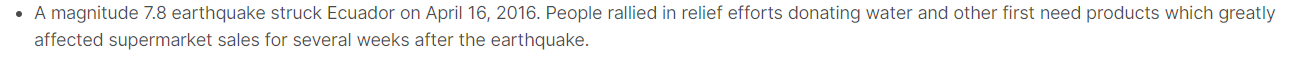 (screenshot from the task description in Kaggle)
<p><i>The same situation with the 'transactions' feature. There is a much bigger <b>max</b> number of transactions in comparison with 87.5% of 'transactions' values. The reason can be the same as I mentioned before, but it is necessary to check it out.</i>
<p><i>One more interesting fact is that the number of promotions is very small in comparison with the whole number of observations (less than 25%). But there is no sense to delete this feature right now, because it seems, that promotions have a good impact on the target.</i>

# Numerical data distribution

In [ ]:
plt.figure(figsize=(20, 40))
for i, current_num_feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, i + 1)
    plt.xlabel(current_num_feature)
    plt.ylabel('count')
    x = train_data.groupby('date')[current_num_feature].mean()
    plt.hist(x=x, bins=80)
    plt.title(current_num_feature)

<i>I'll describe these 4 plots one by one:<br> 1) 'Sales' plot. Distribution of means is not standard, and it is hard to say something about it, having no connection with datetime. But it interesting to explore values, which are out of the general distribution.</i>

In [ ]:
date_and_mean_sales = train_data.groupby('date')['sales'].mean()
date_and_mean_sales_min = date_and_mean_sales[date_and_mean_sales < 100]
date_and_mean_sales_min

<i>It means, that all the values in the left side of 'sales' distribution refer to New Year. That's why we can easily remove these rows - such data are <b>OUTLIERS</b></i>.

In [ ]:
date_and_mean_sales_max = date_and_mean_sales[date_and_mean_sales > 700]
date_and_mean_sales_max

<i>Most of these dates refer to the first days of the month - days, when people get their wages. This fact explains such high 'sales' values. It can be useful in the future: <b>FIRST DAYS OF MONTHS CAUSE BIG 'SALES' NUMBER</b>. What's more, we have an additional information in the task description: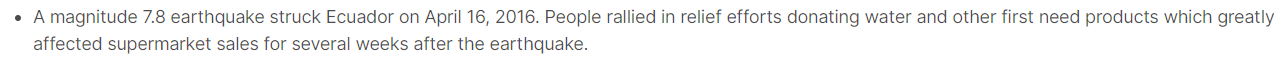
It means, that high 'sales' values on '2016-04-17', '2016-04-18', '2016-05-01' can be explained in this way. According to that, we can clasify observations in these 3 days as <b>outliers</b> and remove them from the dataset. <br> One interesting day is left: '2016-12-23'. It is not the wages-day and it can't be connected to the eartquake. Let's see, what can it be.</i>

In [ ]:
holidays_events_data[holidays_events_data['date'].isin(('2016-04-03', '2016-10-02', '2016-12-04', '2016-12-18', '2016-12-23',
                                                        '2017-01-02', '2017-04-01', '2017-05-01', '2017-06-04', '2017-07-02'))]

<i>I'm pretty sure that holidays these days are nothing more than coincidence. It is necessary to check it out, but I have no idea for that right now. (Actually, we will see later that the existance of the holiday doesn't correlate with the 'sales' at all.)</i>

In [ ]:
onpromotion_data = train_data[train_data['date'].isin(('2016-04-03', '2016-10-02', '2016-12-04',
                                                       '2016-12-18', '2016-12-23', '2017-01-02',
                                                       '2017-04-01', '2017-05-01', '2017-06-04',
                                                       '2017-07-02'))].groupby('date')['onpromotion'].mean()
onpromotion_data

<i>That is what we need. A mean promotions value on the '2016-12-23' is very high (we can look on the 'onpromotion' plot and check it out). This fact could cause such a big 'sales' value. (in this case, we can't clasify observations that day as <b>OUTLIERS</b>, because they can help us while buiding a forecasting model)</i>

In [ ]:
oil_data_to_fillna[oil_data_to_fillna.index.isin(('2016-04-02', '2016-04-03', '2016-10-01', '2016-10-02',
                                                  '2016-12-03', '2016-12-04', '2016-12-17', '2016-12-18',
                                                  '2016-12-22', '2016-12-23', '2017-01-01', '2017-01-02',
                                                  '2017-03-31', '2017-04-01', '2017-04-30', '2017-05-01',
                                                  '2017-06-03', '2017-06-04', '2017-07-01', '2017-07-02'))]

<i>As far as Ecuador is an oil-dependent country, it is necessary to check, if there were any shocks in oil prices these days. But here we can see that there were no shocks, that is why oil price didn't have impact on 'sales' values these days.</i>

<i>2) 'Onpromotion' plot. I don't think that here we can detect some interesting facts. It is necessary to look on the time-dependent plot to learn more about this feature.</i>

In [ ]:
date_and_mean_promo = train_data.groupby('date')['onpromotion'].mean()
date_and_mean_promo_max = date_and_mean_promo[date_and_mean_promo > 10]
date_and_mean_promo_max

In [ ]:
holidays_events_data[holidays_events_data['date'].isin(date_and_mean_promo_max.index)]

<i>All big promotions date back to the last year of the observaions time. And, as we can see, there were no holidays and events those days, that is why it seems that such <b>HIGH 'ONPROMOTION' VALUES HAVE NO CONNECTIONS WITH OTHER FEATURES</b>.
<p>3) Oil price is the independent feature in this task. Rather other features depend on oil price than vice versa.</i>

In [ ]:
date_and_mean_transactions = train_data.groupby('date')['transactions'].mean()
date_and_mean_transactions_min = date_and_mean_transactions[date_and_mean_transactions < 1000]
date_and_mean_transactions_min

In [ ]:
date_and_mean_transactions_max = date_and_mean_transactions[date_and_mean_transactions > 2700]
date_and_mean_transactions_max

In [ ]:
train_data[train_data['date'].isin(date_and_mean_transactions_max.index)].groupby('date')['sales'].mean()

<i>4) 'Transactions' plot. Everything seems logical here. As far as 'sales' number is very low on the 1st January every year, 'transactions' value is also very low these days (in comparison with other values of this feature). As we decided earlier, such observations are outliers, and we will remove them later.
<br>If we look at the highest values of this feature, we see, that all these values date back to the days before Christmas Day. It is logical, because Ecuador is a catolic country, and Christmas Day is one of the most important holidays in the country, which is celebrated on the 25th December. I looked on the 'sales' values these days, and most of them are located on the right edge of the graph, that is why we can clasify observations these days as <b>OUTLIERS</b> and remove them.</i>

In [ ]:
transactions_nan_data = train_data.loc[train_data.isnull()['transactions']]
transactions_nan_data.shape

In [ ]:
number_of_nan_rows = transactions_nan_data.shape[0]
transactions_nan_data['event_type'].value_counts().sum() / number_of_nan_rows

<i>My guess is wrong. Existence of a holiday does not affect the 'transactions' value. Probably, the information about what is the reason of NaN 'transactions' isn't available for us.</i>

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])

In [ ]:
plt.figure(figsize=(20, 40))
for i, current_num_feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, i + 1)
    x = train_data.groupby(pd.Grouper(key='date', freq='W'))[current_num_feature].median()
    trend = x.rolling(window=7, center=True, min_periods=5).mean()
    plt.plot(x)
    trend.plot(x=x, linewidth=3)
    plt.xlabel('date')
    plt.ylabel('median ' + current_num_feature)
    plt.title(current_num_feature)

<i>These trend plots prove guesses about extreme values of 'sales' and 'transactions' numerical features</i>

# Categorical data distribution

In [ ]:
print("Number of unique values:  \n")
for current_cat_feature in categorical_features:
    print(current_cat_feature, '-', train_data[current_cat_feature].nunique())

In [ ]:
cat_features_hist = ['family', 'city', 'locale_name', 'store_nbr']
cat_features_pie = ['state', 'store_type', 'event_type', 'locale', 'transferred', 'cluster']

In [ ]:
plt.figure(figsize=(25, 15))
for i, current_cat_column in enumerate(cat_features_pie):
    plt.subplot(2, 3, i + 1)
    n = train_data[current_cat_column].value_counts()
    plt.pie(n, labels=n.index, radius=1800, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(current_cat_column, color='red')

In [ ]:
plt.figure(figsize=(30, 40))
for i, cat_feature in enumerate(cat_features_hist):
    plt.subplot(len(cat_features_hist), 1, i + 1)
    plt.xlabel(cat_feature)
    plt.ylabel('count')
    sns.countplot(x=train_data[cat_feature], alpha=0.7)
    plt.title(cat_feature)

# Correlations between variables

In [ ]:
train_data_copy = train_data.copy()
train_data_copy = pd.get_dummies(train_data_copy)
train_data_copy.shape

In [ ]:
corr_coefficients = (train_data_copy.corr().where(np.triu(np.ones(train_data_copy.corr().shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

In [ ]:
corr_coefficients[:30]

In [ ]:
corr_coefficients[:-10:-1]

<i>The highest correlation coefficients refer to pairs like 'state' - 'city' or 'event_type' - 'description' or 'locale_name' - 'description', which don't give us any new information. As we will see later, all information about holidays is excess, because the correlation between a binary feature indicating the existence of a holiday on a particular day and all other features is very close to zero.</i>

In [ ]:
train_data_copy = train_data.copy().drop(['event_type', 'locale', 'locale_name', 'description', 'state'], axis=1)
train_data_copy['transferred'] = np.where((train_data_copy['transferred'] == True), 1, train_data_copy['transferred'])
train_data_copy['transferred'] = np.where((train_data_copy['transferred'] == False), 1, train_data_copy['transferred'])
train_data_copy['transferred'] = train_data_copy['transferred'].fillna(0)
train_data_copy['transferred'].value_counts()

is_holiday = pd.get_dummies(train_data_copy['transferred'])
train_data_copy = pd.concat((is_holiday, train_data_copy), axis=1)
train_data_copy = train_data_copy.rename(columns={1: "is_holiday"})
train_data_copy = train_data_copy.drop([0, 'transferred'], axis=1)

train_data_copy['transactions'] = train_data_copy['transactions'].fillna(0)

train_data_copy = pd.get_dummies(train_data_copy)

corr = train_data_copy.corr()
plt.figure(figsize=(30, 25))

sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.3)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

<i>That is the prove: there is no correlation between 'is_holiday' feature and other features. It means that <b>THERE IS NO REASON TO SAVE ALL THE FEATURES, WHICH DESCRIBE HOLIDAYS AND EVENTS</b> - their influence on target and other features is very close to 0.</i>

<i>Some more interesting findings from this graph:
    <br>- <b>target ('sales') correlates well with 'onptomotions' feature</b> (it is obvious) <b> with two goods categories: 'beverages' and 'grocery'</b> can be explained in this way: beverages and especially gracery goods are first consumption goods, that is why number of 'sales' is always pretty high.
    <br>- some store types, such as 'store_type_A' and 'store_type_C' correlate well with 'transactions' feature. It means that if observation refered to 'store_type_A', 'transactions' value would be bigger than if observation refered to any other 'store_type'. There is an opposite situation, when we are talking about 'store_type_C'.
    <br>- some cities correlates well with store types (for example, 'city_Quito' with 'store_type_A'). It means that in Quoto city there are a lot of stores with type 'A' in comparison with other store types. And this fact cause that, for example, 'city_Quoto' correlates well with 'transactions' feature.</i>

# Dependence on the target

<i>In this part I'd like to explore the connection with the target of the following features: 'family', 'onpromotion' and 'dcoilwtico', because 'onpromotion' feature correlates well with the target, the same as some categories from 'family' feature. It is interesting that oil price doesn't correlate well with the 'sales' feature, because Ecuador economy is oil-dependent. But maybe there is more complex dependency between these two features.</i>

In [ ]:
plt.figure(figsize=(20, 10))
oil_and_sales_data = train_data.groupby('date')[['dcoilwtico', 'sales']].mean()
plt.xlabel('oil value')
plt.ylabel('mean sales')
plt.scatter(x='dcoilwtico', y='sales', data=oil_and_sales_data)
plt.title('oil price and mean sales')

In [ ]:
oil_and_sales_data.corr()

In [ ]:
plt.figure(figsize=(20, 10))
oil_and_sales_data = train_data.groupby('date')[['dcoilwtico', 'sales']].median()
plt.xlabel('oil value')
plt.ylabel('median sales')
plt.scatter(x='dcoilwtico', y='sales', data=oil_and_sales_data)
plt.title('oil price and median sales')

In [ ]:
oil_and_sales_data.corr()

<i>Here we can see that <b>CORRELATION BETWEEN OIL PRICE AND SALES IS PRETTY BIG.</b> The last time the correlation coefficient was calculated incorrectly because the sales values per day were not averaged. Now everything is logical. Moreover, the second value is more fair, because there we calculated correlation coefficient with the help of the median 'sales' value. (more resistant to outliers)</i>

In [ ]:
family_values = train_data['family'].unique()

In [ ]:
plt.figure(figsize=(20, 130))
for i, family in enumerate(family_values):
    plt.subplot(17, 2, i + 1)
    average_sales = train_data[train_data['family'] == family].groupby('date')['sales'].median()
    trend = average_sales.rolling(window=365, center=True, min_periods=183).mean()
    plt.ylabel('mean sales')
    ax = average_sales.plot(alpha=0.5)
    ax = trend.plot(ax=ax, linewidth=3)
    plt.title(family, color='red')

In [ ]:
plt.figure(figsize=(20, 10))
for i, family in enumerate(['books', 'baby care']):
    plt.subplot(1, 2, i + 1)
    average_sales = train_data[train_data['family'] == family].groupby('date')['sales'].mean()
    trend = average_sales.rolling(window=365, center=True, min_periods=4).mean()
    plt.ylabel('mean sales')
    ax = average_sales.plot(alpha=0.5)
    ax = trend.plot(ax=ax, linewidth=3)
    plt.title(family, color='red')

<i>We can say that the number of sales in general has a positive dynamic (for example, 'automotive', 'bread/bakery', 'grocery i', 'personal care', ...).<br>Some of the product types have a negative dynamic (such as lingerie).<br>Some goods have very interesting sales distribution (books, produce, home care, ladieswear, ...), and we can't say right now, what is the reason of that.<br>Also some goods families have seasonal increase in sales('school and office supplies', 'liquor, wine, beer', 'grocery ii', 'frozen foods'). It is necessary to make deseasonalized plots, they will help better understand trends. I'll do it later.
    <p>Now let's have a look on some spikes and drops in 'sales', which don't belong to the general trend.
</i>

<b>BOOKS</b>

In [ ]:
date_and_books_mean = train_data[train_data['family'] == 'books'].groupby('date')['sales'].mean()
date_and_books_mean_max = date_and_books_mean[date_and_books_mean > 0]
date_and_books_mean_max.head(10)

<i>'2016-10-08' is a date which corresponds to the begginning of books sales.</i>

In [ ]:
holidays_events_data[holidays_events_data['date'] == '2016-10-08']

In [ ]:
books_promotions = train_data[train_data['family'] == 'books'].groupby('date')['onpromotion'].mean()
books_promotions[books_promotions.index == '2016-10-08']

In [ ]:
date_and_books_mean_max.shape

In [ ]:
transactions_and_books_mean = train_data[train_data['family'] == 'books'].groupby('date')['transactions'].mean()
transactions_and_books_mean[transactions_and_books_mean > 0].shape

<b>!!!</b>

<i>It seems to be illogical: when we are talking about books, mean 'transactions' value is more that 0 almost every day since observations started (1682 days). But, as fas as we know, books 'sales' became more than 0 only on '2016-10-08' (287 days in general).</i>

<b>LAWN AND GARDEN</b>

In [ ]:
date_and_garden_mean = train_data[train_data['family'] == 'lawn and garden'].groupby('date')['sales'].mean()
date_and_garden_mean_max = date_and_garden_mean[date_and_garden_mean > 50]
date_and_garden_mean_max

In [ ]:
garden_data = train_data[train_data['date'].isin(('2017-02-13', '2017-02-14', '2017-05-13'))]
garden_data = garden_data[garden_data['family'] == 'lawn and garden']
garden_data = garden_data.groupby('date')['onpromotion'].mean()
garden_data

In [ ]:
garden_full_data = sorted(train_data[train_data['family'] == 'lawn and garden'].groupby('date')['onpromotion'].mean().tolist())
garden_full_data[:-10:-1]

In [ ]:
holidays_events_data[holidays_events_data['date'].isin(('2017-02-13', '2017-02-14', '2017-05-13'))]

In [ ]:
oil_data_to_fillna[oil_data_to_fillna.index.isin(('2017-02-11', '2017-02-12', '2017-02-13', 
                                                  '2017-02-14', '2017-05-12', '2017-05-13'))]

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('sales')
plt.ylabel('count')
x = train_data[train_data['family'] == 'lawn and garden']['sales']
plt.hist(x=x, bins=80)
plt.title('lawn and garden sales')

In [ ]:
all_lawn_and_garden_data = train_data[train_data['family'] == 'lawn and garden']
len(all_lawn_and_garden_data[all_lawn_and_garden_data['sales'] > 100].index) / len(all_lawn_and_garden_data.index)

In [ ]:
lawn_and_garden_max_sales = train_data[train_data['date'].isin(('2017-02-13', '2017-02-14', '2017-05-13'))]
lawn_and_garden_max_sales = lawn_and_garden_max_sales[lawn_and_garden_max_sales['family'] == 'lawn and garden']['sales']
lawn_and_garden_max_sales[lawn_and_garden_max_sales > 100]

<i>These observations are <b>OUTLIERS</b> and we can remove them from the dataset.</i>

<i><b>GROCERY I</b></i>

In [ ]:
gracery_and_mean_sales_data = train_data[train_data['family'] == 'grocery i'].groupby('date')[['date', 'sales']].mean()
gracery_and_mean_sales_data[gracery_and_mean_sales_data['sales'] > 8000]

<i>First four observations are outliers, and we had already decided to remove them (because they connect with the earthquake).</i>

In [ ]:
gracery_data = train_data[train_data['date'] == '2017-04-01']
gracery_data = gracery_data[gracery_data['family'] == 'grocery i']
gracery_data['onpromotion'].mean()

In [ ]:
holidays_events_data[holidays_events_data['date'] == '2017-04-01']

<i>Probably such big 'sales' value on '2017-04-01' is a result of two facts: first day of the month -> people get their wages; pretty big promotion 'value' (only 1% of all observations in the dataset have bigger 'onpromotion' value). That is why it is not an outlier.</i>

In [ ]:
plt.figure(figsize=(20, 70))
for i, family in enumerate(family_values):
    plt.subplot(len(family_values) // 3, 3, i + 1)
    current_value_data = train_data[train_data['family'] == family].groupby('date')['sales'].mean()
    sns.distplot(current_value_data, color='g', bins=100, hist_kws={'alpha': 0.4})
    plt.title(family)

<i>These plots show that, roughly speaking, sales distributions of all families divided on two parts: <br>1) Normal or close to normal (such as 'automotive', 'bread/bakery', 'cleaning', 'eggs', 'grocery', 'lingerie', ...). Interesting fact that most of distributions from this category have right asymmetry (asymmetry coefficient is positive). The prove is below.<br>2) Distribution, where the biggest density is concentrated in zero or near zero. Other data is distributed differently (some values such as 'home and kitchen i', 'ladieswear' have something like normal distributions). It means that such goods categories aren't essential for people, that is why a number of sales during the day mostly is equal to 0.
    <p><b>Interesting fact: first consumption goods are normally distributed, and seasonal goods that do not have a constant demand are distributed differently.</b>
</i>

In [ ]:
for family in family_values:
    skew = train_data[train_data['family'] == family].groupby('date')['sales'].mean().skew()
    print(f'{family}: {skew:.2f}')

<i>Let's exclude zeros from second-type families and re-build distributions.</i>

In [ ]:
second_type_families = ['baby care', 'books', 'celebration', 'home and kitchen i', 'home and kitchen ii',
                        'home care', 'ladieswear', 'magazines', 'pet supplies', 'players and electronics', 
                        'produce', 'school and office supplies']
second_type_families_without_zeros = train_data[(train_data['family'].isin(second_type_families)) & 
                                                (train_data['sales'] > 0)][['date', 'family', 'sales']]
second_type_families_without_zeros.shape

In [ ]:
plt.figure(figsize=(20, 20))
for i, family in enumerate(second_type_families):
    plt.subplot(len(second_type_families) // 3, 3, i + 1)
    current_value_data = second_type_families_without_zeros[second_type_families_without_zeros['family'] == family].groupby('date')['sales'].mean()
    sns.distplot(current_value_data, color='g', bins=100, hist_kws={'alpha': 0.4})
    plt.title(family)

<i><b>After excluding 'sales' equal to zero from second-type families, we can see that such categories are also distributed normally.</b></i>

In [ ]:
for family in family_values:
    current_family_data = train_data[train_data['family'] == family][['onpromotion', 'sales']]
    print('\033[91m' + family + '\033[0m')
    print(current_family_data.corr())
    print()

<i><b>Correlation between 'onpromotion' feature and the target depence on the 'family' feature.</b> Promotions related to such  categories as 'school and office supplies', 'produce', 'home care', 'home and kitchen', 'beauty' and 'beverages' have a good impact on the target (the bigger the promotion, the more sales).</i>

In [ ]:
plt.figure(figsize=(20, 80))
for i, family in enumerate(family_values):
    plt.subplot(len(family_values) // 3, 3, i + 1)
    current_value_data = train_data[train_data['family'] == family].groupby('date')[['onpromotion', 'sales']].mean()
    plt.xlabel('promotions value')
    plt.ylabel('mean sales')
    plt.scatter(x='onpromotion', y='sales', data=current_value_data, alpha=0.3)
    plt.title(family)

<i>There is no other relationship between these features, except for linear.</i>

In [ ]:
train_data_copy = train_data.copy()
train_data_copy.head()

In [ ]:
plt.figure(figsize=(20, 140))
for i, family in enumerate(family_values):
    ax = plt.subplot(17, 2, i + 1)
    for city in train_data_copy['city'].unique():
        average_sales = train_data_copy[(train_data_copy['family'] == family) & 
                                        (train_data_copy['city'] == city)].groupby('date')['sales'].mean()
        trend = average_sales.rolling(window=365, center=True, min_periods=183).mean()
        trend.plot(ax=ax, linewidth=3, label=city)
        plt.ylabel('mean sales')
    plt.title(family)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(x=train_data['store_type'], alpha=0.7, data=train_data)

In [ ]:
plt.figure(figsize=(20, 140))
for i, family in enumerate(family_values):
    ax = plt.subplot(17, 2, i + 1)
    for store_type in train_data_copy['store_type'].unique():
        average_sales = train_data_copy[(train_data_copy['family'] == family) &
                                        (train_data_copy['store_type'] == store_type)].groupby('date')['sales'].mean()
        trend = average_sales.rolling(window=365, center=True, min_periods=183).mean()
        trend.plot(ax=ax, linewidth=3, label=store_type)
        handles, labels = ax.get_legend_handles_labels()
        plt.ylabel = 'mean sales'
        plt.legend(handles, labels, loc='lower center')
    plt.title(family)
    plt.legend(train_data_copy['store_type'].unique())

<i>As we can see, there are common trends in different categories, but mean sales values are more or less depending on the type of store. Despite the fact that type A stores are not the majority, the average number of sales in it is higher than in the others.</i>